### 1. Imports

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
import gym
import numpy as np
from stable_baselines3 import PPO, A2C
from matplotlib import pyplot as plt

In [2]:
# Import classes
from rl_environment import Environment

### 2. Environment creation

#### Parameters for Simulation

In [3]:
number_of_regional_warehouses = 1
max_inventory_amount_regional_warehouses = 30
max_inventory_amount_central_warehouse = 60
customer_demand_per_step = [2,2,3]  # List needs one entry per regional warehouse 
simulation_length = 40
lead_time = 2
shipment_amount = [8]  # Regarding regional warehouses
with_manufacturer = False
cw_shipment_amount = 10  # Regarding central warehosue
manufacturer_prod_capacity_per_step = 5
shipment_var_cost_per_unit = 0.02
shipment_fixed_cost = .25  # Reward penalty
inventory_holding_cost_multiplier = 1 # Standard = 1; Can be lowered; Not higher that 1
demand_fluctuation = 1
lead_time_fluctuation = 1

#### Parameters for Agent Training

In [4]:
algorithm = "PPO"  # "PPO" or "A2C"
training_steps = 50000

print("-> Equals to " + str(int(training_steps/simulation_length)) + " simulation training rounds")

-> Equals to 1250 simulation training rounds


#### Creating Environment

In [5]:
env = Environment(number_of_regional_wh = number_of_regional_warehouses, 
                  rw_inventory_limit = max_inventory_amount_regional_warehouses, 
                  cw_inventory_limit = max_inventory_amount_central_warehouse,
                  demand = customer_demand_per_step,
                  sim_length = simulation_length,
                  lead_time = lead_time,
                  shipment_amount = shipment_amount,
                  manufacturer = with_manufacturer,
                  cw_shipment_amount = cw_shipment_amount,
                  mf_prod_capacity = manufacturer_prod_capacity_per_step,
                  shipment_var_cost_per_unit = shipment_var_cost_per_unit,
                  shipment_fixed_cost = shipment_fixed_cost,
                  inventory_holding_cost_multiplier = inventory_holding_cost_multiplier,
                  demand_fluctuation = demand_fluctuation,
                  lead_time_fluctuation = lead_time_fluctuation
                 )

env.print_environment_information()

Simulation created with the following parameters:
________________________________________________________________________________
Simulation | Round 1
-------------------
-> Active shipments:
No active shipments

-> Warehouses:
central_warehouse ; Inventory: 20
regional_warehouse_1 ; ID: 1 ; Inventory: 10 ; Demand: 2 ; Lost sales: 0
________________________________________________________________________________
Environment Information
-----------------------
-> Gym spaces:
Observation space: Dict(rw_inventories:MultiDiscrete([31]), shipments:MultiDiscrete([2]))
Action space: MultiDiscrete([2])
Starting state: {'rw_inventories': array([10]), 'shipments': array([0])}

-> Reward penalty per shipment size:
Shipment of 8: 0.41000000000000003
________________________________________________________________________________


### 3. RL model training

###### Model Selection
PPO (Proximal Policy Optimization)
https://openai.com/blog/openai-baselines-ppo/

A2C
https://openai.com/blog/baselines-acktr-a2c/

In [6]:
if algorithm.upper() == "PPO":
    trained_model = PPO("MultiInputPolicy", env, verbose=1)
elif algorithm.upper() == "A2C":
    trained_model = A2C("MultiInputPolicy", env, verbose=1)
else:
    print("Model not found")
    exit()
trained_model.learn(total_timesteps=training_steps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40       |
|    ep_rew_mean     | -6.15    |
| time/              |          |
|    fps             | 1118     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 40         |
|    ep_rew_mean          | -5.22      |
| time/                   |            |
|    fps                  | 788        |
|    iterations           | 2          |
|    time_elapsed         | 5          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.02019262 |
|    clip_fraction        | 0.361      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.67

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 40           |
|    ep_rew_mean          | 2.24         |
| time/                   |              |
|    fps                  | 660          |
|    iterations           | 11           |
|    time_elapsed         | 34           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0059231566 |
|    clip_fraction        | 0.0714       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.301       |
|    explained_variance   | 0.0603       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.259        |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00777     |
|    value_loss           | 0.589        |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 40           |
|    ep_rew_mean          | 2.83         |
| time/                   |              |
|    fps                  | 663          |
|    iterations           | 21           |
|    time_elapsed         | 64           |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0012198836 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.179       |
|    explained_variance   | 0.0386       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.534        |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.000593    |
|    value_loss           | 0.98         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

###### Learning Curve

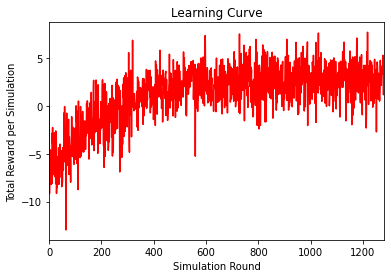

In [7]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(env.total_reward, color="red")
plt.title("Learning Curve")
plt.xlim(0, len(env.total_reward))
plt.ylabel("Total Reward per Simulation")
plt.xlabel("Simulation Round")
plt.show()

### 4. Run simulation

In [8]:
# Reset environment for simulation
state = env.reset()
done = False

# Graph data
inventory_levels = {}
for rw_id in env.simulation.get_regional_warehouses():
    inventory_levels[rw_id] = [0]
    
cw_inventory_level = []

actions = {}
for rw_id in env.simulation.get_regional_warehouses():
    actions[rw_id] = [0]

# Run simulation with model
while not done:
    action, _states = trained_model.predict(state)
    state, reward, done, info = env.step(action)
    
    # For Graph
    i = 1
    for inv in info["RW Invs:"]:
        inventory_levels[i].append(inv)
        i += 1
    try:
        cw_inventory_level.append(info["CW Inv:"])
    except:
        pass
    
    i = 1
    for act in info["Action:"]:
        actions[i].append(act)
        i += 1
    
    # print(env.simulation.print_state())
    for i in info:
        print(i, info[i], end=" | ")
    print()
    
print("\n", env.evaluation_parameters())

Round: 1 | RW Invs: [9] | Shipments [0] | Action: [0] | Reward: 0.1 | 
Round: 2 | RW Invs: [8] | Shipments [0] | Action: [0] | Reward: 0.11 | 
Round: 3 | RW Invs: [7] | Shipments [0] | Action: [0] | Reward: 0.12 | 
Round: 4 | RW Invs: [5] | Shipments [1] | Action: [1] | Reward: -0.24 | 
Round: 5 | RW Invs: [10] | Shipments [0] | Action: [0] | Reward: 0.09 | 
Round: 6 | RW Invs: [9] | Shipments [0] | Action: [0] | Reward: 0.1 | 
Round: 7 | RW Invs: [6] | Shipments [0] | Action: [0] | Reward: 0.14 | 
Round: 8 | RW Invs: [5] | Shipments [1] | Action: [1] | Reward: -0.24 | 
Round: 9 | RW Invs: [10] | Shipments [0] | Action: [0] | Reward: 0.09 | 
Round: 10 | RW Invs: [9] | Shipments [0] | Action: [0] | Reward: 0.1 | 
Round: 11 | RW Invs: [8] | Shipments [0] | Action: [0] | Reward: 0.11 | 
Round: 12 | RW Invs: [7] | Shipments [1] | Action: [1] | Reward: -0.29 | 
Round: 13 | RW Invs: [5] | Shipments [1] | Action: [0] | Reward: 0.17 | 
Round: 14 | RW Invs: [12] | Shipments [0] | Action: [0] | 

###### Inventory level graphs

RW 1 data:
Inventory: [0, 9, 8, 7, 5, 10, 9, 6, 5, 10, 9, 8, 7, 5, 12, 11, 10, 9, 7, 5, 3, 10, 7, 4, 1, 0, 6, 5, 12, 11, 8, 5, 3, 1, 7, 6, 11, 9, 8, 5, 4]
Actions: [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]
____________________________________________________________________________________________________


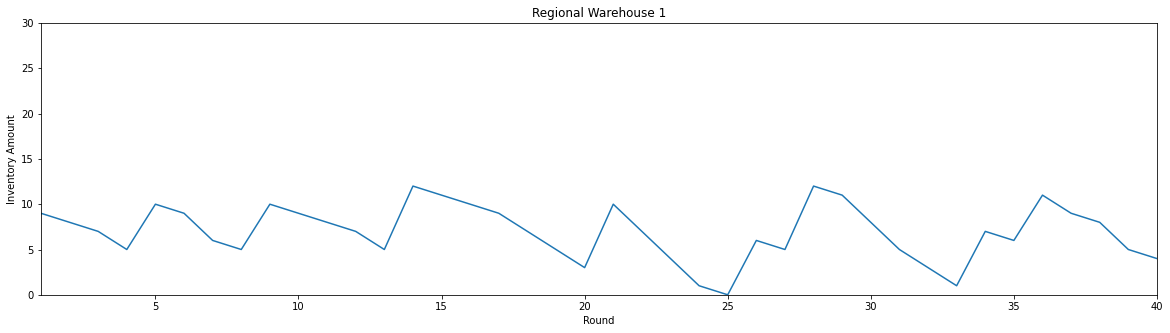

In [9]:
# Plot inventories of regional warehouses

plt.rcParams["figure.figsize"] = (20, 5)

for rw_id in inventory_levels:
    plt.subplot(1, number_of_regional_warehouses, rw_id)
    plt.plot(inventory_levels[rw_id])
    plt.title("Regional Warehouse " + str(rw_id))
    plt.ylim(0, max_inventory_amount_regional_warehouses)
    plt.xlim(1, simulation_length)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")
    
    if True:
        print("RW", rw_id, "data:")
        print("Inventory:", inventory_levels[rw_id])
        print("Actions:", actions[rw_id])
        print("_"*100)

plt.show()

In [10]:
# Plot central warehouse inventory (Only display if simulated by adding a manufacturer)
if len(cw_inventory_level) != 0:
    plt.rcParams["figure.figsize"] = (20, 5)
    plt.plot(cw_inventory_level, color="green")
    plt.title("Central Warehouse")
    plt.ylim(0, max_inventory_amount_central_warehouse)
    plt.xlim(0, simulation_length-1)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")
    plt.show()